# **ML/DL (2주차 1교시)**

## Q1. 이론문제(서술형)

과거에는 시그모이드(Sigmoid) 함수를 주로 사용했으나, 최근 딥러닝(Deep Learning) 모델에서는 은닉층의 활성화 함수로 주로 ReLU를 사용합니다. 층이 깊은 모델에서 시그모이드를 사용할 때 발생하는 '기울기 소실(Vanishing Gradient)' 문제란 무엇이며, ReLU가 이를 어떻게 해결하는지 서술해주세요.

[답변 작성란]

1. 기울기 소실(Vanishing Gradient) 문제란? :
활성화 함수의 미분값이 1보다 작아 층이 깊어질수록 역전파 과정에서 가중치가 소실되는 문제
2. ReLU의 해결 방식 :
ReLU 함수의 미분값은 0 or 1로, 반복해서 곱해져도 가중치가 유지된다

## Q2. 개념 구현

MNIST 손글씨 분류기 만들기 & 최적화 기법 비교

### 0. 환경 설정 및 데이터 로드

실습에 필요한 라이브러리를 불러오고, MNIST 데이터셋을 다운로드합니다.

이 셀은 수정하지 말고 그대로 실행해주세요.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 적용
set_seed(42)

# 2. 데이터셋 로드 (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 훈련 데이터
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 테스트 데이터
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 데이터 확인
print(f"Train Data Size: {len(trainset)}")
print(f"Test Data Size: {len(testset)}")

Train Data Size: 60000
Test Data Size: 10000


### [문제 1] CNN 모델 구조 설계 (빈칸 채우기)

강의에서 배운 CNN 구조를 조금 더 깊게 만들어 봅니다.

2단 레이어(Conv-Pool-Conv-Pool) 구조를 직접 설계해 주세요.

[구현 조건]

1. Layer 1: Conv(1 $\to$ 32ch) $\to$ ReLU $\to$ MaxPool

2. Layer 2: Conv(32 $\to$ 64ch) $\to$ ReLU $\to$ MaxPool

3. FC Layer: Flatten 후 10개의 클래스로 분류

[힌트: 차원 계산]

- 입력: `28x28`

- Layer 1 통과 후 (Pool): `14x14`

- Layer 2 통과 후 (Pool): `?`

In [2]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # ==========================================
        # [TODO 1] 2단 레이어 구조 완성하기
        # ==========================================

        # Layer 1: 입력 1채널 -> 출력 32채널
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Layer 2: 입력 32채널 -> 출력 64채널
        self.layer2 = nn.Sequential(
            # 힌트: Conv2d(in, out, kernel, padding=1)
            # 힌트: MaxPool2d(kernel)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # FC Layer
        # 최종 Feature Map 크기 계산: 28 -> 14 -> 7
        # 따라서 64채널 * 7 * 7 크기가 됨
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        # Flatten (1차원으로 펼치기)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

# 모델 생성 및 구조 확인
model = DeepCNN()
print(model)

DeepCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)



### [문제 2] 학습 루프(Training Loop) 완성하기

딥러닝 모델 학습의 핵심인 경사하강법(Gradient Descent) 3단계를 코드로 구현해 주시면 됩니다.

- Step 1: 기울기 초기화 (`zero_grad`)

- Step 2: 역전파를 통한 기울기 계산 (`backward`)

- Step 3: 가중치 업데이트 (`step`)

In [3]:
def train_model(model, optimizer, criterion, epochs=3, model_name="Model"):
    loss_history = []
    model.train() # 학습 모드 전환

    print(f"=== {model_name} Training Start ===")

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:

            # ==========================================
            # [TODO 2] 경사하강법 3단계 구현하기
            # ==========================================

            # 1. 이전 배치의 기울기 초기화
            optimizer.zero_grad()

            # 순전파 (Forward) 및 Loss 계산
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 2. 역전파 (Backward) - 기울기 계산
            loss.backward()

            # 3. 파라미터 업데이트 (Step)
            optimizer.step()

            running_loss += loss.item()

        # 에포크별 평균 Loss 저장
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")

    return loss_history

### [문제 3] Optimization 비교: SGD vs Adam

위에서 만든 `train_model` 함수를 사용하여 SGD와 Adam Optimizer의 성능을 비교해 봅니다.

- 실험 A: SGD (Learning Rate = 0.01)

- 실험 B: Adam (Learning Rate = 0.001)

=== SGD Training Start ===
Epoch [1/3] Loss: 0.5858
Epoch [2/3] Loss: 0.1867
Epoch [3/3] Loss: 0.1326
=== Adam Training Start ===
Epoch [1/3] Loss: 0.1626
Epoch [2/3] Loss: 0.0497
Epoch [3/3] Loss: 0.0360


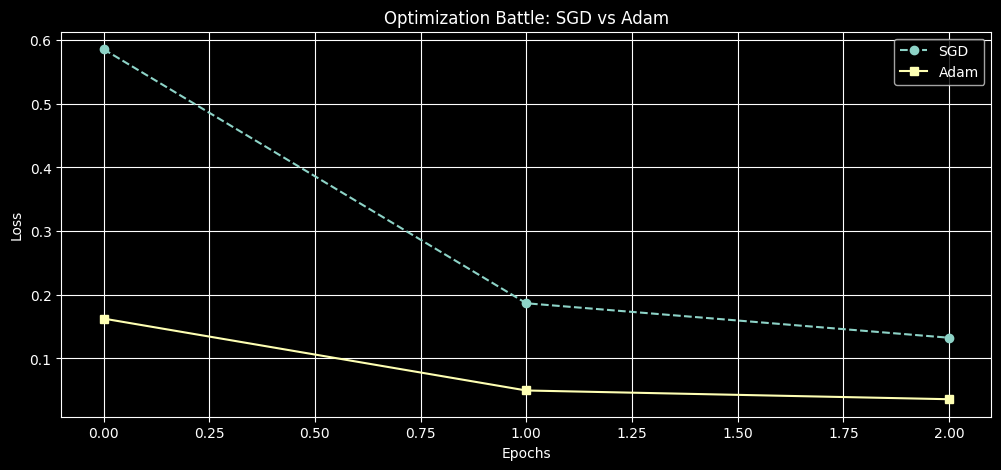

In [4]:
# 공통 손실 함수
criterion = nn.CrossEntropyLoss()

# -------------------------------------------------
# CASE A: SGD Optimizer
# -------------------------------------------------
set_seed(42) # 시드 초기화 (공정한 비교 위해)
model_sgd = DeepCNN()

# [TODO 3-1] SGD Optimizer 설정 (lr=0.01)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01)

sgd_losses = train_model(model_sgd, optimizer_sgd, criterion, epochs=3, model_name="SGD")

# -------------------------------------------------
# CASE B: Adam Optimizer
# -------------------------------------------------
set_seed(42) # 시드 초기화
model_adam = DeepCNN()

# [TODO 3-2] Adam Optimizer 설정 (lr=0.001)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

adam_losses = train_model(model_adam, optimizer_adam, criterion, epochs=3, model_name="Adam")


# -------------------------------------------------
# 결과 시각화
# -------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(sgd_losses, label='SGD', marker='o', linestyle='--')
plt.plot(adam_losses, label='Adam', marker='s')
plt.title('Optimization Battle: SGD vs Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Q. 그래프를 보고 알 수 있는 점에 대해 작성해주세요.

- SGD: Adam보다 loss가 느리게 감소한다. 느리게 수렴하지만 안정적인 학습이 가능하다

- Adam: SGD보다 초기 epochs에서 loss가 빠르게 감소한다. SGD보다 빠르게 학습이 가능하다